In [1]:
# IMPORTS FOR SCRIPT
import pandas as pd
import numpy as np
import calendar
import datetime
import math
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.mode.chained_assignment = None
pd.set_option('max_rows', 300)
pd.set_option('max_columns', 25)  

# pd.set_option('max_rows', None)  - if required to see all results

In [2]:
""" API for CURRENCIES
import requests
import alpha_vantage

API_URL = "https://www.alphavantage.co/query"

data = {
    "function": "DIGITAL_CURRENCY_INTRADAY",
    "symbol": "ETH",
    "market": "EUR",
    "datatype": "csv",
    "apikey": "E196CKVJSSDKIZM3",
    }
response = requests.get(API_URL, params=data)
print(response.text)
"""

' API for CURRENCIES\nimport requests\nimport alpha_vantage\n\nAPI_URL = "https://www.alphavantage.co/query"\n\ndata = {\n    "function": "DIGITAL_CURRENCY_INTRADAY",\n    "symbol": "ETH",\n    "market": "EUR",\n    "datatype": "csv",\n    "apikey": "E196CKVJSSDKIZM3",\n    }\nresponse = requests.get(API_URL, params=data)\nprint(response.text)\n'

# 1.0 Load and clean historical BTC-EUR price data

In [3]:
# Set column names for btc-eur price and volume data import
coinbase_btc_eur_cols = ['Time',
                   'Coin_price_EUR',
                   'Coin_volume',
                    ]

# File source is 'http://api.bitcoincharts.com/v1/csv/' (14million rows) - note skiprows=2000000 to get to 04/11/2017
coinbase_btc_eur = pd.read_csv('coinbase_BTC_EUR.csv', header=0, names=coinbase_btc_eur_cols, skiprows=2000000)

In [4]:
# Write a function to transform UNIX Timestamp into datetime format
# Note, could change strftime('%Y-%m-%d %H') to reduce granularity of data and not show minutes

def unix_to_datetime(i):
    u = datetime.datetime.fromtimestamp(
        int(i)
    ).strftime('%Y/%m/%d %H:%M')
    return u

In [5]:
# Apply unix_to_datetime function to every row in the coinbase_btc_eur dataframe
coinbase_btc_eur['Timestamp'] = coinbase_btc_eur["Time"].apply(lambda row: unix_to_datetime(row))

In [6]:
# Write an aggregation function that finds the mean price per minute and the total volume per minute - output this to a new DF
coinbase_btc_eur_min=coinbase_btc_eur.groupby('Timestamp', as_index=False).agg({'Coin_price_EUR':'mean', 'Coin_volume':'sum'})

In [7]:
# Convert date in 'Timestamp' column from strftime to datetime
coinbase_btc_eur_min['Timestamp'] = pd.to_datetime(coinbase_btc_eur_min['Timestamp'], format="%Y/%m/%d %H:%M")

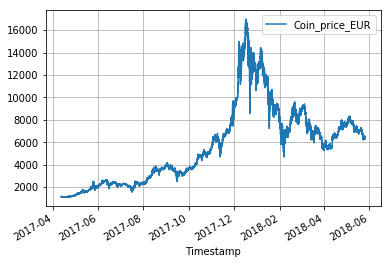

In [8]:
# BTC-EUR price from May 2015
coinbase_btc_eur_min.plot(kind='line',x='Timestamp',y='Coin_price_EUR', grid=True);

# 1.1 Load and clean Coinbase COIN wallet file

<b> Coinbase ETL Function

In [9]:
def coinbase_load(csv_name):
    # Account specific parameters
    bank_name = 'Visa debit ********0110'
    
    # Read in file and drop redundant columns - Source is Coinbase [BTC] Wallet Transaction History report'
    f = pd.read_csv(csv_name, header=0, encoding='latin-1')
    # Read what currency the file is for
    cryptocurrency = f['Currency'][0]
    # Drop the redundant coulumns
    f.drop(['Currency',
            'Instantly Exchanged',
            'Transfer Fee Currency',
            'Order Paid Out',
            'Order Custom Parameter',
            'Order Tracking Code',
            'Order BTC',
            'Order Currency',
            'Order Price',
            'Recurring Payment ID',
            'Bitcoin Hash (visit https://www.coinbase.com/tx/[HASH] in your browser for more info)',
            ], axis=1, inplace=True)
    
    # Set column names for Coinbase wallet transactions history data import
    rename_map = {f.columns[0]:'Timestamp',
              f.columns[1]:'Balance',
              f.columns[2]:'Amount',
              f.columns[3]:'To',
              f.columns[4]:'Notes',
              f.columns[5]:'Transfer_total',
              f.columns[6]:'Transfer_currency',
              f.columns[7]:'Transfer_fee',
              f.columns[8]:'Transfer_method',
              f.columns[9]:'Transfer_id',
              f.columns[10]:'Coinbase_id'
             }

    # Rename the columns to the map
    f.rename(columns=rename_map, inplace=True)
    
    # Convert the timestamp into datetime format (make sure to import calendar first)
    f['Timestamp'] = pd.to_datetime(f['Timestamp'], format="%d/%m/%Y %H:%M")
    
    """ Where there is no transfer method listed it means BTC has been sent/received to/from another 
    3rd party wallet (some of which I may own, e.g. Binance/GDAX). If this transfer is positive the 
    account is funded, else withdrawn from. A new column 'Type' is created to capture this information."""
    f.loc[(f['Transfer_method'].isnull()) & (f['Amount']>0),'Type'] = 'Fund'
    f.loc[(f['Transfer_method'].isnull()) & (f['Amount']<0),'Type'] = 'Withdraw'
    
    # Third party transactions data is added to replace NaN in applicable columns (Transfer Fee, Transfer_currency, Transfer_method)
    # Note, transaction_fee for BTC is not actually 0, but fee has already been paid in BTC terms prior to amount shown
    f.loc[f['Transfer_method'].isnull(),'Transfer_fee'] = 0
    f.loc[f['Transfer_method'].isnull(),'Transfer_currency'] = cryptocurrency
    f.loc[f['Transfer_method'].isnull(),'Transfer_method'] = 'Third_party'
    
    # The transactions that are not classified as 'Third_party' are trades to and from the Coinbase btc wallet
    # These transactions are labelled as buy or sell in the 'Type' column
    f.loc[(f['Transfer_method'] != 'Third_party') & (f['Amount']>0),'Type'] = 'Buy'
    f.loc[(f['Transfer_method'] != 'Third_party') & (f['Amount']<0),'Type'] = 'Sell'

    # Input bank details to classify Type as Fund
    f.loc[f['Transfer_method'] == bank_name,'Type'] = 'Fund'
    
    # Write a function to calculate the transacted price per coin in transaction currency (post fees)
    def price_per_coin(Transfer_total,coin):
        if coin < 0:
            price_per_coin = Transfer_total/-coin
            return price_per_coin
        else:
            price_per_coin = Transfer_total/coin
            return price_per_coin
    
    # Run the price_per_coin function on each transaction (where a Transfer_total value exists)
    f['Transaction_price_per_coin'] = f.apply(lambda row: price_per_coin(row["Transfer_total"], row["Amount"]), axis=1)
    return f

<b> Get Coin prices function

In [10]:
def get_coin_prices(wallet, coin_prices):
    # Merge the Coinbase wallet with COIN-EUR price information
    wallet = pd.merge(wallet, coin_prices.iloc[:,:2], on="Timestamp", how="left")

    # Function to take a timestamp, price.isnull pair and increment the timestamp until a non-null price is found
    def fill_missing_prices(t, p):
        t = t + datetime.timedelta(0,60) 
        p = coin_prices.loc[coin_prices['Timestamp'] == t, 'Coin_price_EUR'].values[0]
        v = coin_prices.loc[coin_prices['Timestamp'] == t, 'Coin_volume'].values[0]
        print ('missing time updated to:', t)
        if math.isnan(p) == True:
            fill_missing_prices(t, p)
        else:
            return (p)

    # Apply the fill_missing_prices function to each line the btc_wallet where price information is missing
    wallet_missing = wallet[wallet['Coin_price_EUR'].isnull()]
    wallet.loc[wallet['Coin_price_EUR'].isnull(),'Coin_price_EUR'] = wallet_missing.apply(lambda row: fill_missing_prices(row["Timestamp"], row["Coin_price_EUR"]), axis=1);

    return wallet

<b> Get Fiat currencies function

In [11]:
def get_fiat_currencies(wallet, COIN):
    
    # Load Euro-GBP exchange rates - note granularity is only monthly and from Jan 2017
    eur_rate = pd.read_csv('eur_rate.csv', header=0)
    eur_rate['Date'] = pd.to_datetime(eur_rate['Date'], format="%m/%Y")
    eur_rate['Year'] = eur_rate['Date'].dt.year
    eur_rate['Month'] = eur_rate['Date'].dt.month

    # Create year and month columns in both DFs to look up values on
    wallet['Year'] = wallet['Timestamp'].dt.year
    wallet['Month'] = wallet['Timestamp'].dt.month
    wallet['Day'] = wallet['Timestamp'].dt.day
    # Then merge on eur_rate DF
    wallet = pd.merge(wallet, eur_rate.iloc[:,1:], on=['Year','Month'], how="left")

    # Create a Coin transaction price column in Euros. If GBP, convert from GBP transaction price. 
    # If Euros, just copy across and if [COIN] transfer, take market price 
    wallet.loc[wallet['Transfer_currency'] == 'GBP','Transaction_price_EUR'] = wallet.loc[wallet['Transfer_currency'] == 'GBP', 'Transaction_price_per_coin'] * wallet.loc[wallet['Transfer_currency'] == 'GBP', 'EUR_GBP']
    wallet.loc[wallet['Transfer_currency'] == 'EUR','Transaction_price_EUR'] = wallet.loc[wallet['Transfer_currency'] == 'EUR', 'Transaction_price_per_coin']
    wallet.loc[wallet['Transfer_currency'] == COIN,'Transaction_price_EUR'] = wallet.loc[wallet['Transfer_currency'] == COIN, 'Coin_price_EUR'] # Note, having to use spot price rather than transaction price for these transfers

    # Create a COIN transaction total value in Euros column
    wallet['Transaction_total_EUR'] = wallet['Transaction_price_EUR'] * wallet['Amount']

    # Create a COIN balance equivalent in Euros column (note using spot price, not transaction price)
    wallet['Coin_balance_EUR'] = wallet['Coin_price_EUR'] * wallet['Balance']

    # Create a BTC transaction price column in GBP
    wallet.loc[wallet['Transfer_currency'] == 'EUR','Transaction_price_GBP'] = wallet.loc[wallet['Transfer_currency'] == 'EUR', 'Transaction_price_per_coin'] / wallet.loc[wallet['Transfer_currency'] == 'EUR', 'EUR_GBP']
    wallet.loc[wallet['Transfer_currency'] == 'GBP','Transaction_price_GBP'] = wallet.loc[wallet['Transfer_currency'] == 'GBP', 'Transaction_price_per_coin']
    wallet.loc[wallet['Transfer_currency'] == COIN,'Transaction_price_GBP'] = wallet.loc[wallet['Transfer_currency'] == COIN, 'Coin_price_EUR'] / wallet.loc[wallet['Transfer_currency'] == COIN, 'EUR_GBP']

    # Create a BTC transaction total value in GBP column
    wallet['Transaction_total_GBP'] = wallet['Transaction_price_GBP'] * wallet['Amount']

    # Create a COIN balance equivalent in GBP column (note using spot price, not transaction price)
    wallet['Coin_balance_GBP'] = (wallet['Coin_price_EUR'] / wallet['EUR_GBP']) * wallet['Balance']
    
    # Rename columns to be coin specific
    rename_map = {
            'Transaction_price_per_coin': 'Transaction_price_per_'+COIN,
            'Coin_price_EUR': COIN+'_price_EUR',
            'Coin_balance_EUR': COIN+'_balance_EUR',
            'Coin_balance_GBP':COIN+'_balance_GBP',
            'Amount':COIN+'_amount',
             }

    # Rename the columns to the map
    wallet.rename(columns=rename_map, inplace=True)
    
    # Reorder the columns
    cols = btc_wallet.columns.tolist()
    cols = ['Timestamp',
     'Balance',
     'BTC_balance_GBP',
     'BTC_amount',
     'Transaction_total_GBP',
     'Transfer_method',
     'Type',
     'Transaction_price_GBP',
     'Transaction_price_EUR',
     'BTC_price_EUR',     
     'Transfer_total',
     'Transfer_currency',
     'Transfer_fee',
     'Transaction_price_per_BTC',
     'Transaction_total_EUR',
     'BTC_balance_EUR',
     'Transfer_id',
     'Coinbase_id',
     'Year',
     'Month',
     'Day',       
     'EUR_GBP',
     'To',
     'Notes'
    ];
    
    wallet = wallet[cols]

    return wallet

In [12]:
btc_wallet = coinbase_load('btc_wallet_transaction_history.csv')

In [13]:
btc_wallet = get_coin_prices(btc_wallet, coinbase_btc_eur_min)

missing time updated to: 2017-10-28 06:50:00
missing time updated to: 2018-01-01 04:09:00


In [14]:
btc_wallet = get_fiat_currencies(btc_wallet, 'BTC')

In [15]:
btc_wallet.head()

,Timestamp,Balance,BTC_balance_GBP,BTC_amount,Transaction_total_GBP,Transfer_method,Type,Transaction_price_GBP,Transaction_price_EUR,BTC_price_EUR,Transfer_total,Transfer_currency,Transfer_fee,Transaction_price_per_BTC,Transaction_total_EUR,BTC_balance_EUR,Transfer_id,Coinbase_id,Year,Month,Day,EUR_GBP,To,Notes
0,2017-05-05 11:06:00,0.001000,1.261462,0.001000,1.261462,Third_party,Fund,1261.461814,1475.269500,1475.269500,NaN,BTC,0.0,NaN,1.475270,1.475270,NaN,590cbf423ad22301ff5aad8b,2017,5,5,1.169492,tyrone.hunt07@gmail.com,NaN
1,2017-05-05 11:10:00,0.831200,1049.378877,0.830200,1048.116390,Third_party,Fund,1262.486618,1476.468000,1476.468000,NaN,BTC,0.0,NaN,1225.763734,1227.240202,NaN,590cc0013ad2230e225aaf6e,2017,5,5,1.169492,tyrone.hunt07@gmail.com,NaN
2,2017-05-06 09:54:00,1.656069,2039.113524,0.824869,1015.659096,Third_party,Fund,1231.297435,1439.992500,1439.992500,NaN,BTC,0.0,NaN,1187.805188,2384.726954,NaN,590dffaf75d36c00013cffda,2017,5,6,1.169492,NaN,NaN
3,2017-05-07 02:27:00,1.240469,1523.829167,-0.415600,-510.535448,Third_party,Withdraw,1228.429856,1436.638889,1436.638889,NaN,BTC,0.0,NaN,-597.067122,1782.106020,NaN,590ee86584d424f881b55ffa,2017,5,7,1.169492,tinasparkle222@yahoo.co.uk,NaN
4,2017-05-23 15:09:00,1.694969,2900.970537,0.454500,777.885083,Third_party,Fund,1711.518334,2001.607000,2001.607000,NaN,BTC,0.0,NaN,909.730382,3392.661835,NaN,5924b304dc2bd90e678a7016,2017,5,23,1.169492,tyrone.hunt07@gmail.com,NaN


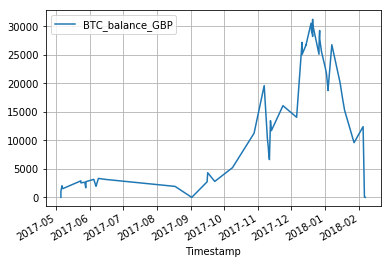

In [16]:
# Amount invested in BTC in Coinbase
btc_wallet.plot(kind='line',x='Timestamp',y='BTC_balance_GBP', grid=True);

# 1.2 Load and clean GDAX transactions file (BTC)

In [17]:
# Set column names for gdax exchange transactions data import
gdax_transaction_cols = ['Timestamp',
                   'Account_name',
                   'Type',
                   'Balance',
                   'Trade_amount',
                   'Trade_currency',
                   'Trade_amount_usd',
                   'Record_id'
                    ]

# File source is 'coinbase GDAX Transactions report'
gdax_trans = pd.read_csv('gdax_transactions.csv', header=0, names=gdax_transaction_cols)

In [18]:
# Define a function to 'fix' the gdax time series into the correct format
    def fix_timestamp(t):
    tyear = t[0:4]
    tmon = t[5:7]
    tday = t[8:10]
    ttime = t[11:19]
    tdat = str(tday+'/'+tmon+'/'+tyear+' '+ttime)
    return tdat

In [19]:
# Apply the fix_timestamp function to each timestamp row in the gdax_trans DF
gdax_trans['Timestamp'] = gdax_trans.apply(lambda row: fix_timestamp(row["Timestamp"]), axis=1)

In [20]:
# Convert Timestamp series into datetime format
gdax_trans['Timestamp'] = pd.to_datetime(gdax_trans['Timestamp'], format="%d/%m/%Y %H:%M:%S")

In [21]:
# The 'Balance' column actually stores the same value for every record - so delete it, and fix later
gdax_trans['Balance']= 0.00

In [22]:
# Extract just the BTC wallet transactions
gdax_trans_btc = gdax_trans.loc[gdax_trans['Account_name'] == 'BTC',:]

In [23]:
# Set the trade classification types as buy/sell, or fund/withdraw
gdax_trans_btc.loc[(gdax_trans_btc['Type'] == 'match') & (gdax_trans_btc['Trade_amount']>0),'Type'] = 'Buy'
gdax_trans_btc.loc[(gdax_trans_btc['Type'] == 'match') & (gdax_trans_btc['Trade_amount']<0),'Type'] = 'Sell'
gdax_trans_btc.loc[(gdax_trans_btc['Type'] == 'transfer') & (gdax_trans_btc['Trade_amount']>0),'Type'] = 'Fund'
gdax_trans_btc.loc[(gdax_trans_btc['Type'] == 'transfer') & (gdax_trans_btc['Trade_amount']<0),'Type'] = 'Withdraw'

In [24]:
# Create a cumulative balance column in BTC for gdax
gdax_trans_btc['Balance'] = gdax_trans_btc['Trade_amount'].cumsum();

In [25]:
# Remove the seconds in the timestamp column
gdax_trans_btc['Timestamp'] = gdax_trans_btc['Timestamp'].map(lambda x: x.replace(second=0))

In [26]:
# Join on the bitcoin price information in euros
gdax_trans_btc = pd.merge(gdax_trans_btc, coinbase_btc_eur_min.iloc[:,:2], on="Timestamp", how="left")

In [27]:
# Drop the redundant columns
gdax_trans_btc.drop(['Account_name','Trade_currency'], axis=1, inplace=True)

# Rename the remaining columns to be the same as Coinbase data
rename_map = {
'Timestamp':    'Timestamp', 
'Type':  'Type', 
'Balance':  'Balance',
'Trade_amount':  'BTC_amount',
}
gdax_trans_btc.rename(columns=rename_map, inplace=True)

In [28]:
# Load USD-GBP exchange rates - note granularity is daily and from May 2017
usd_gbp_rate = pd.read_csv('usd_gbp_rate.csv', header=0)
usd_gbp_rate['Date'] = pd.to_datetime(usd_gbp_rate['Date'], format="%d/%m/%Y")
usd_gbp_rate['Year'] = usd_gbp_rate['Date'].dt.year
usd_gbp_rate['Month'] = usd_gbp_rate['Date'].dt.month
usd_gbp_rate['Day'] = usd_gbp_rate['Date'].dt.day

In [29]:
# Create year and month columns in both DFs to look up values on
gdax_trans_btc['Year'] = gdax_trans_btc['Timestamp'].dt.year
gdax_trans_btc['Month'] = gdax_trans_btc['Timestamp'].dt.month
gdax_trans_btc['Day'] = gdax_trans_btc['Timestamp'].dt.day
# Then merge on usd_gbp_rate DF
gdax_trans_btc = pd.merge(gdax_trans_btc, usd_gbp_rate.iloc[:,1:], on=['Year','Month','Day'], how="left")

In [30]:
# Load Euro-GBP exchange rates - note granularity is only monthly and from Jan 2017
eur_rate = pd.read_csv('eur_rate.csv', header=0)
eur_rate['Date'] = pd.to_datetime(eur_rate['Date'], format="%m/%Y")
eur_rate['Year'] = eur_rate['Date'].dt.year
eur_rate['Month'] = eur_rate['Date'].dt.month

# Then merge on eur_rate DF
gdax_trans_btc = pd.merge(gdax_trans_btc, eur_rate.iloc[:,1:], on=['Year','Month'], how="left")

In [31]:
# Convert trade value in usd to gpb trade value
gdax_trans_btc['Transaction_total_GBP'] = gdax_trans_btc['Trade_amount_usd'] / gdax_trans_btc['USD_GBP']

# Convert trade value to trade price
gdax_trans_btc['Transaction_price_GBP'] = gdax_trans_btc['Transaction_total_GBP'] / gdax_trans_btc['BTC_amount']

# Create a BTC balance equivalent in EUR column
gdax_trans_btc['BTC_balance_EUR'] = gdax_trans_btc['BTC_price_EUR'] * gdax_trans_btc['Balance']

# Create a BTC balance equivalent in GBP column
gdax_trans_btc['BTC_balance_GBP'] = gdax_trans_btc['BTC_balance_EUR'] / gdax_trans_btc['EUR_GBP']

# Fill out the transfer method as GDAX for this dataset
gdax_trans_btc['Transfer_method'] = 'GDAX'

# Calculate the transaction price in EUR
gdax_trans_btc['Transaction_price_EUR'] = gdax_trans_btc['Transaction_price_GBP'] * gdax_trans_btc['EUR_GBP']

# Calculate the transaction value in EUR
gdax_trans_btc['Transaction_total_EUR'] = gdax_trans_btc['Transaction_total_GBP'] * gdax_trans_btc['EUR_GBP']

KeyError: 'BTC_price_EUR'

In [ ]:
# Set columns in the order to match that of btc_wallet
cols2 = gdax_trans_btc.columns.tolist()
cols2 = ['Timestamp',
 'Balance',
 'BTC_balance_GBP',
 'BTC_amount',
 'Transaction_total_GBP',
 'Transfer_method',
 'Type',
 'Transaction_price_GBP',
 'Transaction_price_EUR',
 'BTC_price_EUR',     
 #'Transfer_total',
 #'Transfer_currency',
 #'Transfer_fee',
 #'Transaction_price_per_coin',
 'Transaction_total_EUR',
 'BTC_balance_EUR',
 #'Transfer_id',
 #'Coinbase_id',
 'Record_id',
 'Year',
 'Month',
 'Day',
 'EUR_GBP',
 'USD_GBP'
];

gdax_trans_btc = gdax_trans_btc[cols2]

In [ ]:
gdax_trans_btc

In [ ]:
# Amount invested in BTC in GDAX
gdax_trans_btc.plot(kind='line',x='Timestamp',y='BTC_balance_GBP', grid=True);

# 1.3 Combine BTC accounts

In [ ]:
# Concatenate Coinbase and GDAX BTC wallets
BTC = pd.concat([btc_wallet,gdax_trans_btc])

In [ ]:
# Set columns in the order to match that of btc_wallet and gdax_btc combined
cols3 = gdax_trans_btc.columns.tolist()
cols3 = ['Timestamp',
 'Balance',
 'BTC_balance_GBP',
 'BTC_amount',
 'Transaction_total_GBP',
 'Transfer_method',
 'Type',
 'Transaction_price_GBP',
 'Transaction_price_EUR',
 'BTC_price_EUR',     
 'Transfer_total',
 'Transfer_currency',
 'Transfer_fee',
 'Transaction_price_per_coin',
 'Transaction_total_EUR',
 'BTC_balance_EUR',
 'Transfer_id',
 'Coinbase_id',
 'Record_id',
 'Year',
 'Month',
 'Day',
 'EUR_GBP',
 'USD_GBP'
];

BTC = BTC[cols3].sort_values('Timestamp')

In [ ]:
# Create a function to assist 'smoothing' the profile, i.e. matching and deleting transfers between Coinbase and GDAX
def smoother_function(transfer_method, transfer_type, BTC_amount):
    if (transfer_method == 'Third_party') and (transfer_type == 'Withdraw'):
        s = BTC_amount * -1
        return s
    elif (transfer_method == 'GDAX') and transfer_type == 'Fund':
        s = BTC_amount
        return s

In [ ]:
# Apply smoothing function to each line, identifying transactions between Coinbase and GDAX
BTC['Smoother'] = BTC.apply(lambda row: smoother_function(row["Transfer_method"], row["Type"], row["BTC_amount"]), axis=1)

In [ ]:
# This function takes a row from the BTC transfer_duplicates DF, checks to see if there are 2 duplicate values, and if there are, deletes these indexes from BTC
def smoother_function_part2(year, month, day, smoother):
    smooth_index = []
    r = transfer_duplicates[(transfer_duplicates['Year'] == year) & 
    (transfer_duplicates['Month'] == month) &
    ((transfer_duplicates['Day'] == day) | (transfer_duplicates['Day'] == day+1)) &
    (transfer_duplicates['Smoother'] == smoother)]
    
    if len(r.index) == 2:
        smooth_index.append(r.index[0])
        smooth_index.append(r.index[1])
        BTC.drop(smooth_index, inplace=True);

In [ ]:
# Identify rows which are transfers from Coinbase to GDAX
transfer_duplicates = BTC.loc[BTC['Smoother'].isnull()==False,['Year','Month','Day','Smoother']];

In [ ]:
# Apply the smoother cleaning function (part 2), by checking indexs in transfer_duplicates DF and then updating BTC DF
transfer_duplicates.apply(lambda row: smoother_function_part2(row["Year"], row["Month"], row["Day"], row["Smoother"]), axis=1);

In [ ]:
# Update cumulative balance column in BTC and in GBP equivalent
BTC['Balance'] = BTC['BTC_amount'].cumsum()
BTC['BTC_balance_GBP'] = (BTC['BTC_price_EUR'] / BTC['EUR_GBP']) * BTC['Balance']
BTC['BTC_balance_EUR'] = BTC['BTC_price_EUR'] * BTC['Balance']

# Re-sort by timestamp
BTC = BTC.sort_values('Timestamp')

In [ ]:
BTC

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
BTC.plot(ax=ax, kind='line',x='Timestamp',y='Balance', grid=True)
ax.set_ylabel("BTC Balance", size=14)
ax.set_xlabel("Date", size=14);
